In [1]:
# Initial imports
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [2]:
import psycopg2
from Resources.config import PostgrePw
import pandas as pd

In [3]:
# Create the connection engine
conn_string = f"host='localhost' dbname='crime_data_db' user='postgres' password='{PostgrePw}'"
conn = psycopg2.connect(conn_string)

In [4]:
# establish a connection to Postgre
try:
    conn = psycopg2.connect(conn_string)
    print("Connection successful")
    
    # query and load the table
    query = "SELECT * FROM crime_data"
    
    # load into pandas DF
    crime_data_df = pd.read_sql_query(query,conn)
    
    # Display Df
    print(crime_data_df.head())
    
except Exception as e:
    print(f"Error connecting to the database: {e}")
# since the data is loaded into pandas, we can close the connection!
finally:
    if 'conn' in locals():
        conn.close()
        print("Connection closed")

Connection successful


C:\Users\Brittney Watts\AppData\Local\Temp\ipykernel_15976\2369206151.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crime_data_df = pd.read_sql_query(query,conn)


              x              y  year incident_report_id             location  \
0  1.448107e+06  543688.000087  2021   20210807-1032-01         500 W 4TH ST   
1  1.406833e+06  499666.999875  2021   20210714-0714-02     14200 PERUGIA WY   
2  1.439801e+06  548658.999988  2017   20170521-1457-02         3000 RUSH AV   
3  1.449394e+06  572029.000163  2022   20221028-1713-02       4900 SUNSET RD   
4  1.432559e+06  550084.000090  2020   20201214-0857-00  4600 TUCKASEEGEE RD   

        city state    zip  x_coord_public  y_coord_public  ...  \
0  CHARLOTTE    NC  28202         1448107          543688  ...   
1  CHARLOTTE    NC  28273         1406833          499667  ...   
2  CHARLOTTE    NC  28208         1439801          548659  ...   
3  CHARLOTTE    NC  28269         1449394          572029  ...   
4  CHARLOTTE    NC   None         1432559          550084  ...   

   location_type_description  place_type_description  \
0                   Outdoors  Public/Non-Residential   
1         

In [5]:
# CHECK THE DATA TYPES, NUMBER OF RECORDS, AND COLUMN NAMES 
print(f'THE DATA TYPES:\n{crime_data_df.dtypes}\n')
print(f'NUMBER OF RECORDS: {len(crime_data_df)}\n')
print(f'COLUMN NAMES: {crime_data_df.columns}\n')
print(f'NUMBER OF UNIQUE VALUES PER COLUMNS:\n{crime_data_df.nunique()}')

THE DATA TYPES:
x                                   float64
y                                   float64
year                                  int64
incident_report_id                   object
location                             object
city                                 object
state                                object
zip                                  object
x_coord_public                        int64
y_coord_public                        int64
latitude_public                     float64
longitude_public                    float64
division_id                          object
cmpd_patrol_division                 object
npa                                   int64
date_reported                datetime64[ns]
date_incident_began                  object
date_incident_end                    object
address_description                  object
location_type_description            object
place_type_description               object
place_detail_description             object
clearance_status

In [12]:
# checking cleared types 
clearance_types = crime_data_df['clearance_status'].value_counts()
print(clearance_types)
clearance_detail_types = crime_data_df['clearance_detail_status'].value_counts()
print(clearance_detail_types)

clearance_status
3    394705
2    129424
0    109573
4     21443
1      4741
Name: count, dtype: int64
clearance_detail_status
Open                                           393008
Cleared by Arrest                              109573
Cleared by Other Means                          71311
Victim Chose not to Prosecute                   38617
Unfounded                                       19562
Located (Missing Persons and Runaways only)     17934
Cleared by Arrest by Another Agency              4741
Unfounded-Referred to Other Agency               1881
Cleared, Pending Arrest Validation               1697
Prosecution Declined by DA                       1220
By Death of Offender                              329
Extradition Declined                               13
Name: count, dtype: int64


In [6]:
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'clearance_status'. 
crime_data_df['clearance_status']= label_encoder.fit_transform(crime_data_df['clearance_status'])

In [9]:
# Separate the target variable, y
y = crime_data_df['clearance_status']

# Separate the features, X, and drop unnecessary columns
X = crime_data_df[['year', 'zip', 'division_id', 'npa', 'date_reported', 
                   'place_detail_description', 'highest_nibrs_code']]

# Print a preview of both
print(y[:5])
print(X.head())

0    3
1    3
2    3
3    3
4    3
Name: clearance_status, dtype: int32
   year    zip division_id  npa date_reported      place_detail_description  \
0  2021  28202          01  476    2021-08-07        Air/Bus/Train Terminal   
1  2021  28273          21   82    2021-07-14  Apartment/Duplex Private Res   
2  2017  28208          02  293    2017-05-21             Private Residence   
3  2022  28269          11  125    2022-10-28                   Hotel/Motel   
4  2020   None          27  199    2020-12-14                      Day Care   

  highest_nibrs_code  
0                23H  
1                23F  
2                290  
3                11D  
4                220  


In [ ]:
# Preview the first five entries for the target variable
y[:5]

In [13]:
# encoding features, X, categorical variables
needs_encoding = ['zip', 'division_id', 'npa', 'place_detail_description', 'highest_nibrs_code']

# Apply one-hot encoding to the specified columns
X = pd.get_dummies(X, columns=needs_encoding)

# Print a preview of the encoded features
print(X.head())

   year date_reported  zip_00000  zip_0113  zip_0211  zip_02719  zip_02724  \
0  2021    2021-08-07      False     False     False      False      False   
1  2021    2021-07-14      False     False     False      False      False   
2  2017    2017-05-21      False     False     False      False      False   
3  2022    2022-10-28      False     False     False      False      False   
4  2020    2020-12-14      False     False     False      False      False   

   zip_02727  zip_0712  zip_0713  ...  highest_nibrs_code_90B  \
0      False     False     False  ...                   False   
1      False     False     False  ...                   False   
2      False     False     False  ...                   False   
3      False     False     False  ...                   False   
4      False     False     False  ...                   False   

   highest_nibrs_code_90C  highest_nibrs_code_90D  highest_nibrs_code_90F  \
0                   False                   False              

In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Separate numeric and non-numeric columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler using only numeric columns
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])

# Transform the testing data using the scaler
X_test_scaled = scaler.transform(X_test[numeric_cols])

# If you need to keep non-numeric data for model training
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=numeric_cols), X_train[non_numeric_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=numeric_cols), X_test[non_numeric_cols].reset_index(drop=True)], axis=1)


In [15]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [16]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [19]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
unique_classes = sorted(list(set(y_test)))
cm_df = pd.DataFrame(
    cm, index=[f"Actual {cls}" for cls in unique_classes], columns=[f"Predicted {cls}" for cls in unique_classes]
)

# display confusion matrix DF
print(cm_df.head())

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {acc_score}")

          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            0            0            0        27228            0
Actual 1            0            0            0         1216            0
Actual 2            0            0            0        32474            0
Actual 3            0            0            0        98749            0
Actual 4            0            0            0         5305            0
Accuracy Score: 0.5985803651528744


In [20]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,0,0,27228,0
Actual 1,0,0,0,1216,0
Actual 2,0,0,0,32474,0
Actual 3,0,0,0,98749,0
Actual 4,0,0,0,5305,0


Accuracy Score : 0.5985803651528744
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     27228
           1       0.00      0.00      0.00      1216
           2       0.00      0.00      0.00     32474
           3       0.60      1.00      0.75     98749
           4       0.00      0.00      0.00      5305

    accuracy                           0.60    164972
   macro avg       0.12      0.20      0.15    164972
weighted avg       0.36      0.60      0.45    164972



C:\Users\Brittney Watts\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Brittney Watts\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Brittney Watts\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(1.0, 'year')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

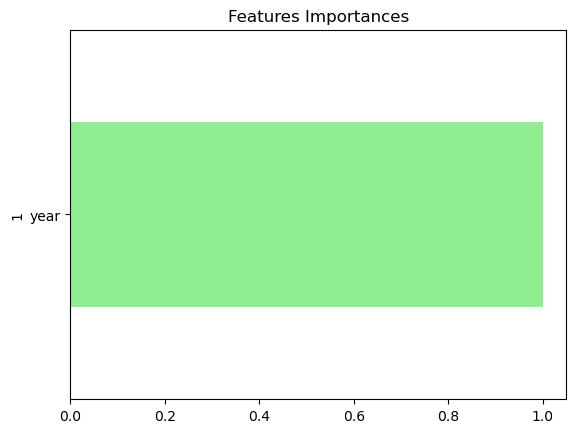

In [22]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)